In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time
from sklearn.metrics import roc_curve, auc
from scipy import interp
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 12, 8

In [3]:
df2 = pd.read_csv('merged_S15-30_L0-10_M5_4400_shuffled.csv', sep=';')
df2 = df2[[i for i in list(df2.columns) if i not in ('Unnamed: 0.1')]]
df2 = df2.fillna(value=0.0)

In [4]:
df2[df2['is_target']==1]['GC precentage'].describe()

count    2112.000000
mean       33.651413
std        16.030037
min         0.000000
25%        21.739130
50%        32.142857
75%        45.144284
max        85.714286
Name: GC precentage, dtype: float64

In [5]:
dfX = df2[[i for i in list(df2.columns) if i not in ('is_target')]]
dfY = df2['is_target']

In [6]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=200)

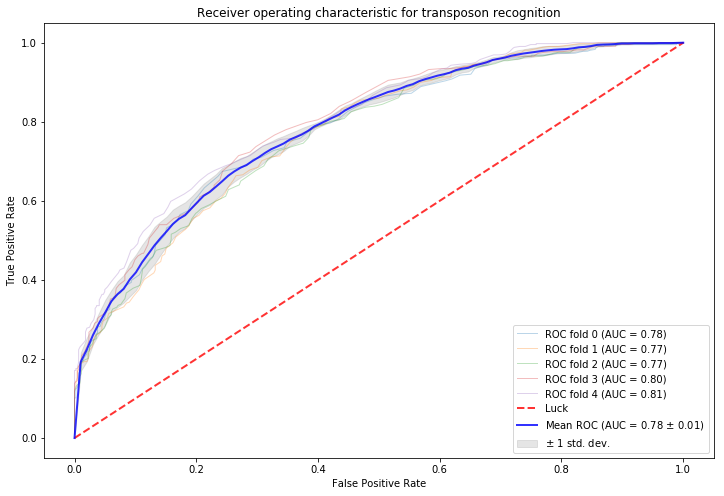

In [7]:
folded_data = model_selection.KFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0

for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
    probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(
        fpr,
        tpr,
        lw=1,
        alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)
    )

    i += 1
plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    lw=2,
    color='r',
    label='Luck',
    alpha=.8
)
fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color='grey',
    alpha=.2,
    label=r'$\pm$ 1 std. dev.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for transposon recognition')
plt.legend(loc="lower right")
plt.show()

In [8]:
list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:10]

[('ATA', 0.00761131226251794),
 ('AT', 0.006726604694581747),
 ('GC precentage', 0.006445004415605304),
 ('TAT', 0.006342184215443251),
 ('TA', 0.0062398455326733515),
 ('LS9LS8 - Hydrophilicity (RNA)', 0.005043774871886259),
 ('LS9LS8 - Rise (RNA)', 0.004609179166832854),
 ('LS9LS8 - Entropy (RNA)', 0.004584593321106739),
 ('LP1LP2 - Slide (RNA)', 0.004389712751811235),
 ('LS9LS8 - Roll (RNA)', 0.004380251984194807)]